In [1]:
#Carga de las librerias y definicion de las rutas asociadas
import pandas as pd
import numpy as np
from pathlib import Path
import glob


In [2]:
#Carga de archivos de ventas y de compras 2024-2025
# Ruta base
ruta_base = Path("../data/raw")

# Archivos de ventas
archivos_ventas = sorted(ruta_base.glob("ventas_dcto_items_2024*.xlsx")) + \
                  sorted(ruta_base.glob("ventas_dcto_items_2025*.xlsx"))

# Archivos de compras
archivos_compras = sorted(ruta_base.glob("compras_dcto_items_2024*.xlsx")) + \
                   sorted(ruta_base.glob("compras_dcto_items_2025*.xlsx"))

# Lectura en DataFrames
ventas_items = pd.concat([pd.read_excel(f, engine="openpyxl") for f in archivos_ventas], ignore_index=True)
compras_items = pd.concat([pd.read_excel(f, engine="openpyxl") for f in archivos_compras], ignore_index=True)


In [5]:
# Cargar archivo de artículos
ruta_articulos = ruta_base / "articulos.xlsx"
articulos = pd.read_excel(ruta_articulos, engine="openpyxl")

# Mostrar primeras filas para exploración
print("📦 Primeras filas de artículos:")
display(articulos.head())

# Ver columnas disponibles
print("\n📌 Columnas disponibles en 'articulos':")
print(articulos.columns)


📦 Primeras filas de artículos:


,codigo,barras,nombre,unidad,iva,activo,referencia,kit,volumen,peso,codbscula,reginvima,xunidad
0,130220,8851081200245,SALSA CHILE BEST CHOICE X 880 GRS,UNIDAD,19,S,NaN,False,20,0.0,NaN,NaN,True
1,150704,NaN,ALM. CROISSANT JAMON Y QUESO,UNIDAD,8,S,NaN,False,20,0.0,NaN,NaN,True
2,150703,7708687881488,CB. CREMA CHOCO AVELLANA-ALMENDRA S/A 72,UNIDAD,19,N,NaN,False,20,0.0,NaN,NaN,True
3,150701,8410226017645,ACEITUNA NEGRA SIN HUESOxUn,UNIDAD,19,N,NaN,False,20,0.0,NaN,NaN,True
4,150705,8410226069064,ACEITUNA PICARDIASxUn,UNIDAD,19,N,NaN,False,20,0.0,NaN,NaN,True



📌 Columnas disponibles en 'articulos':
Index(['codigo', 'barras', 'nombre', 'unidad', 'iva', 'activo', 'referencia',
       'kit', 'volumen', 'peso', 'codbscula', 'reginvima', 'xunidad'],
      dtype='object')


In [4]:
#Identificacion de los nombres de las columnas disponibles 
print("📌 Columnas de ventas_items:")
print(ventas_items.columns)

print("\n📌 Columnas de compras_items:")
print(compras_items.columns)



📌 Columnas de ventas_items:
Index(['cod_cliente', 'cliente', 'documento', 'defecha',
       'cod_articulo_servicio', 'nombre_articulo_servicio', 'cantidad',
       'porc_iva', 'vrgravado', 'vrnogravado', 'descuento', 'subtotal',
       'costo', 'utilidadps', 'utilidadpc', 'tipodocumento', 'cuenta',
       'nomcuenta', 'icolicoresunitario', 'bodega', 'vendedor', 'distrito'],
      dtype='object')

📌 Columnas de compras_items:
Index(['cod_cliente', 'cliente', 'documento', 'defecha',
       'cod_articulo_servicio', 'nombre_articulo_servicio', 'cantidad',
       'porc_iva', 'vrgravado', 'vrnogravado', 'descuento', 'subtotal',
       'tipodocumento', 'tipotercero'],
      dtype='object')


In [6]:
#Agregar la columna "mes" a las ventas y las compras 
# Asegúrate de convertir 'defecha' a formato datetime
ventas_items['defecha'] = pd.to_datetime(ventas_items['defecha'])
compras_items['defecha'] = pd.to_datetime(compras_items['defecha'])

# Crear columna 'mes' con formato AAAA-MM
ventas_items['mes'] = ventas_items['defecha'].dt.to_period('M').astype(str)
compras_items['mes'] = compras_items['defecha'].dt.to_period('M').astype(str)


In [7]:
#Calcular ventas y compras mensuales
# Ventas por SKU y mes
ventas_mensuales = ventas_items.groupby(['mes', 'cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].sum().reset_index()
ventas_mensuales.rename(columns={'cantidad': 'ventas_mensuales'}, inplace=True)

# Compras promedio mensual (proxy de inventario)
compras_mensuales = compras_items.groupby(['mes', 'cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].mean().reset_index()
compras_mensuales.rename(columns={'cantidad': 'inventario_promedio_mensual'}, inplace=True)


In [8]:
#Calcular la rotacion mensual 
rotacion_mensual = ventas_mensuales.merge(
    compras_mensuales,
    on=['mes', 'cod_articulo_servicio', 'nombre_articulo_servicio'],
    how='left'
)

# Cálculo de rotación
rotacion_mensual['rotacion_inventario_mensual'] = rotacion_mensual['ventas_mensuales'] / rotacion_mensual['inventario_promedio_mensual']


In [9]:
#Enriquecer la informacion en conjunto con la informacion de "archivos"
rotacion_mensual = rotacion_mensual.merge(
    articulos,
    left_on='cod_articulo_servicio',
    right_on='codigo',
    how='left'
)


In [10]:
# Filtrar valores finitos
rotacion_mensual_filtrada = rotacion_mensual[np.isfinite(rotacion_mensual['rotacion_inventario_mensual'])]
rotacion_mensual_filtrada = rotacion_mensual_filtrada[rotacion_mensual_filtrada['rotacion_inventario_mensual'] >= 0]

In [11]:
#Identificacion de los percentiles
# Calcular percentiles
umbral_bajo = rotacion_mensual_filtrada['rotacion_inventario_mensual'].quantile(0.33)
umbral_medio = rotacion_mensual_filtrada['rotacion_inventario_mensual'].quantile(0.66)


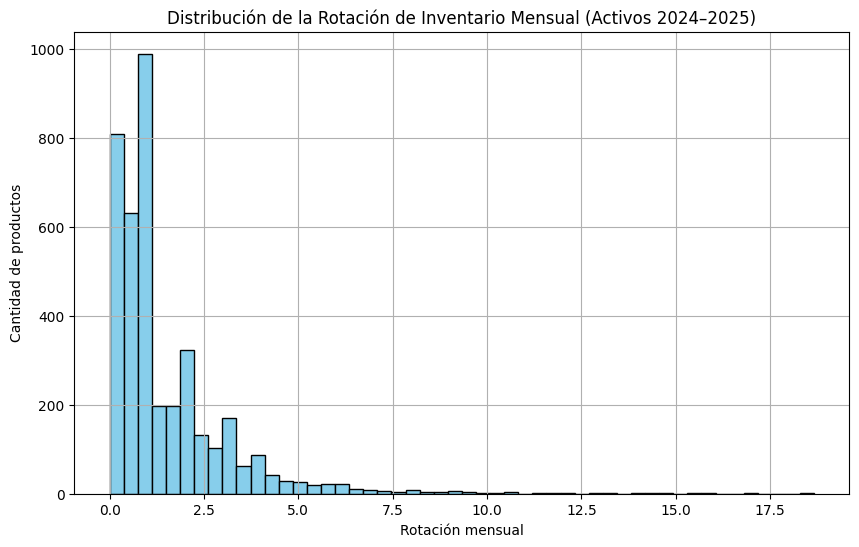

In [13]:
#Ver la distribucion de los datos
import matplotlib.pyplot as plt

# Histograma de la variable de rotación
plt.figure(figsize=(10, 6))
plt.hist(rotacion_mensual_filtrada['rotacion_inventario_mensual'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución de la Rotación de Inventario Mensual (Activos 2024–2025)")
plt.xlabel("Rotación mensual")
plt.ylabel("Cantidad de productos")
plt.grid(True)
plt.show()


In [19]:
# Ver resumen estadístico de la rotación mensual (2024–2025 activos)
rotacion_mensual_filtrada['rotacion_inventario_mensual'].describe().round(2)


count    3940.00
mean        1.49
std         1.66
min         0.00
25%         0.50
50%         1.00
75%         2.00
max        18.67
Name: rotacion_inventario_mensual, dtype: float64

In [21]:
print(f"📉 Umbral para categoría Baja: 0 ≤ rotación ≤ {umbral_bajo:.2f}")
print(f"🔁 Umbral para categoría Media: {umbral_bajo:.2f} < rotación ≤ {umbral_medio:.2f}")
print(f"🚀 Umbral para categoría Alta: rotación > {umbral_medio:.2f}")



📉 Umbral para categoría Baja: 0 ≤ rotación ≤ 0.67
🔁 Umbral para categoría Media: 0.67 < rotación ≤ 1.36
🚀 Umbral para categoría Alta: rotación > 1.36


In [12]:
# Clasificar
def clasificar_rotacion(valor):
    if valor <= umbral_bajo:
        return 'Baja'
    elif valor <= umbral_medio:
        return 'Media'
    else:
        return 'Alta'

rotacion_mensual_filtrada['categoria_rotacion_mensual'] = rotacion_mensual_filtrada['rotacion_inventario_mensual'].apply(clasificar_rotacion)


In [14]:
rotacion_mensual_filtrada['Validar Rotación Mensual'] = ''
rotacion_mensual_filtrada['Requiere Revisión'] = ''
rotacion_mensual_filtrada['Observaciones'] = ''
rotacion_mensual_filtrada['Acciones Sugeridas'] = ''
rotacion_mensual_filtrada['Notas de Apoyo'] = ''


In [15]:
#Orden de las columnas asociadas 
columnas_orden = [
    'cod_articulo_servicio', 'nombre_articulo_servicio', 'rotacion_inventario_mensual',
    'categoria_rotacion_mensual', 'unidad', 'iva', 'activo',
    'Validar Rotación Mensual', 'Requiere Revisión',
    'Observaciones', 'Acciones Sugeridas', 'Notas de Apoyo'
]
rotacion_final = rotacion_mensual_filtrada[columnas_orden]


In [16]:

#Exportacion de los archivos a excel
output_path = "../outputs/reports/rotacion_mensual_validacion_2024_2025.xlsx"
rotacion_final.to_excel(output_path, index=False)
